In [33]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import matplotlib.pyplot as plt

In [41]:
epochs = 5
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [5]:
## normalization with the mean and the standard deviation for mnist dataset
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/tmp/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/tmp/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

100.1%

Extracting /tmp/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/MNIST/raw


113.5%

Extracting /tmp/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/MNIST/raw


100.4%

Extracting /tmp/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/MNIST/raw


180.4%

Extracting /tmp/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/MNIST/raw
Processing...
Done!


In [11]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [18]:
example_data.shape

torch.Size([1000, 1, 28, 28])

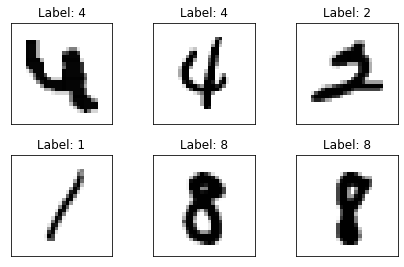

In [32]:
## plot data
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])
    plt.title("Label: {}".format(example_targets[i]))
    plt.imshow(example_data[i][0], cmap=plt.cm.binary)

In [34]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d(p=0.2)
        self.linear1 = nn.Linear(320, 50)
        self.linear2 = nn.Linear(50, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320) ## flatten output
        x = F.relu(self.linear1(x)) ## first linear layer
        x = F.dropout(x, training=self.training)
        x = self.linear2(x) ## second linear layer
        return F.log_softmax(x)

In [57]:
model = MyNet()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [58]:
## Training
train_losses = []
train_counter = []
test_losses = []

## for each epochs
test_counter = [ i * len(train_loader.dataset) for i in range(epochs + 1)]

In [59]:
def train(epoch):
    model.train()
    for idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() ## set the gradient to 0
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if (idx % 10 == 0):
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, idx * len(data), len(train_loader.dataset),
        100. * idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [60]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [61]:
test()
for ep in range(1, epochs + 1):
    train(ep)
    test()

<ipython-input-34-d5d520525937>:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.2990, Accuracy: 955/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.330787
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.121243
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.133407
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.947680
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.985130
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.777946
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.673009
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.734759
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.717155
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.697461
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.342666
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.669080
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.500275
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.414064
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.530483
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.546232
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.372926
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.425704
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.405720
Train Epoch: 1 [12160/

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.368147
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.144180
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.332742
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.228952
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.268401
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.140143
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.208169
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.261885
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.288262
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.292304
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.215163
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.247231
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.360666
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.275477
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.335561
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.456617
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.393041
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.255481
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.264625
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.185038


Train Epoch: 4 [28160/60000 (47%)]	Loss: 0.315400
Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.606811
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.231253
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.271766
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.381293
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.405258
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.113987
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.266934
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.368971
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.233582
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.203256
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.072822
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.266002
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.390406
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.157459
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.191301
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.199061
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.470939
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.292484
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.131923


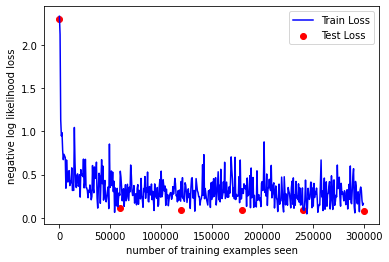

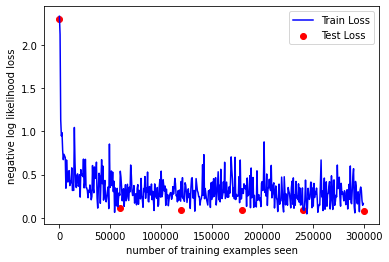

In [63]:
## display the model performance
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig